In [1]:
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from numpy import loadtxt
from PIL import Image
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import os
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy

In [2]:
DATASET = 'SMALL'

In [3]:
def get_ds(root, max_size=1024):
    # Applying Transforms to the Data
    image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])
    
    directories = {
        type_: os.path.join(root, type_) for type_ in next(os.walk(root))[1]
    }
    types = directories.keys()

    # Batch size
    bs = 4

    # Number of classes
    num_classes = 2

    # Load Data from folders
    ds = {
        type_: datasets.ImageFolder(root=directories[type_], transform=image_transform)
                                    for type_ in  directories
    }
    
    dls = {type_: torch.utils.data.DataLoader(ds[type_], batch_size=bs, shuffle=True, num_workers=4)
              for type_ in types
    }
    dls = {type_: {"dl": dls[type_], "size": len(ds[type_]), "cls": ds[type_].classes} for type_ in types}
    return dls

['correct', 'incorrect']


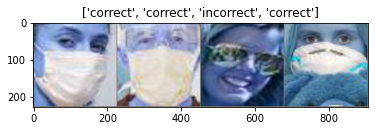

In [4]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataloaders = get_ds(DATASET)


class_names = dataloaders['train']['cls']
print(class_names)
inputs, classes = next(iter(dataloaders['train']['dl']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            full_len = len(dataloaders[phase]["dl"].dataset)
            completed = 0
            for inputs, labels in dataloaders[phase]["dl"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                completed += len(labels)
                print(f"{completed}/{full_len}")
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataloaders[phase]["size"]
            epoch_acc = running_corrects.double() / dataloaders[phase]["size"]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model = torchvision.models.resnet34(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cbpu");model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# Model modification #
# ================== #
model.fc = nn.Linear(512, 2)

In [11]:
# Learning parameters #
# =================== #

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=1)

Epoch 0/0
----------
4/1026
8/1026
12/1026
16/1026
20/1026
24/1026
28/1026
32/1026
36/1026
40/1026
44/1026
48/1026
52/1026
56/1026
60/1026
64/1026
68/1026
72/1026
76/1026
80/1026
84/1026
88/1026
92/1026
96/1026
100/1026
104/1026
108/1026
112/1026
116/1026
120/1026
124/1026
128/1026
132/1026
136/1026
140/1026
144/1026
148/1026
152/1026
156/1026
160/1026
164/1026
168/1026
172/1026
176/1026
180/1026
184/1026
188/1026
192/1026
196/1026
200/1026
204/1026
208/1026
212/1026
216/1026
220/1026
224/1026
228/1026
232/1026
236/1026
240/1026
244/1026
248/1026
252/1026
256/1026
260/1026
264/1026
268/1026
272/1026
276/1026
280/1026
284/1026
288/1026
292/1026
296/1026
300/1026
304/1026
308/1026
312/1026
316/1026
320/1026
324/1026
328/1026
332/1026
336/1026
340/1026
344/1026
348/1026
352/1026
356/1026
360/1026
364/1026
368/1026
372/1026
376/1026
380/1026
384/1026
388/1026
392/1026
396/1026
400/1026
404/1026
408/1026
412/1026
416/1026
420/1026
424/1026
428/1026
432/1026
436/1026
440/1026
444/1026
448/10